# Assignment 1
## Problem 6 - Normalizing Flows

In [25]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

#test123
import matplotlib.pyplot as plt
import numpy as np
import pyro.distributions as dist
import torch
from matplotlib import cm
from src.utils.io import load_image, img_to_bw

import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T

from src.utils.plotting import init_plot_style, show_grayscale_img
#%pylab

init_plot_style()
data_dir='../../data/img/'

&ensp;
<hr style='border:2.2px solid Black'></hr>

#### Data preparation

If necessary, we first have to convert our grayscale icons to a binary image.

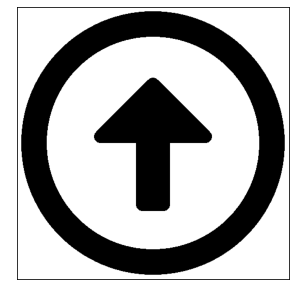

In [26]:
img = img_to_bw(data_dir + 'up.png', data_dir + 'up_bw.png')
show_grayscale_img(img,figsize=(5, 5))

Now we can load the binary image and generate samples from it as described in the assignment sheet.

Our image format is 512 x 512.


(0.0, 512.0)

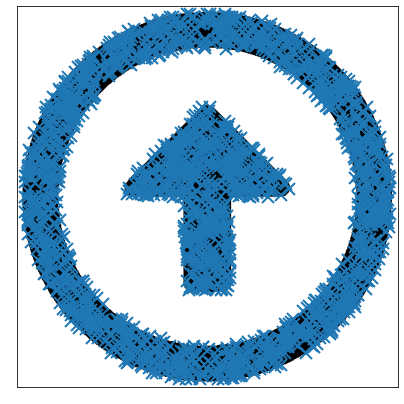

In [27]:
# load image
img = load_image(data_dir + 'up_bw.png')
height, width = img.shape
print(f'Our image format is {width} x {height}.')

# generate training samples
n_samples = 2000 # number of samples to generate
data = np.zeros((n_samples, 2))
rng = np.random.default_rng(seed=0)
i=0
while i < n_samples:
    row = rng.integers(0, height)
    col = rng.integers(0, width)
    if img[row, col] == 0:
        data[i,0] = col
        data[i,1] = row
        i += 1

# plot image with generated samples
show_grayscale_img(img,figsize=(7, 7))
plt.plot( data[:,0], data[:,1], 'x')
plt.xlim([0, width])
plt.ylim([0, height])


&ensp;
<hr style='border:2.2px solid Black'></hr>

### Pre-processing

Our image format is 512x512 px. But in order to further process the samples of the image efficiently using normalizing flows, the samples are normalized to [-1,1]. 

The normalizing flow is implemented using Pyro (see this [Tutorial](https://pyro.ai/examples/normalizing_flows_i.html)). For the coupling transform [`SplineCoupling`](https://docs.pyro.ai/en/stable/distributions.html#pyro.distributions.transforms.SplineCoupling) is used. The input parameter *bound=K* determines the bounding box ([−K,K]×[−K,K]) of the spline - the default value is K=3. 

The training process of the normalizing flow works efficiently when the input is normalized to [-1,1].

In [28]:
data_normalized = (data/512-0.5)*2
print(f'Our pre-processed samples lie in the range [{np.min(data_normalized)} , {np.max(data_normalized)}].')

Our pre-processed samples lie in the range [-0.9609375 , 0.9609375].


<hr style='border:1.5px solid Black'></hr>
<hr style='border:0.5px solid Gray'></hr>

### Task a) Implement a coupling flow (spline coupling flow)

<hr style='border:0.5px solid Gray'></hr>
<hr style='border:1.5px solid Black'></hr>


First, the base distribution is specified. In our case it is chosen as a random variable $X$ with the distribution of a simple multivariate Gaussian with zero mean and unit covariance matrix: 

$$ \mathbf{X} \sim \mathcal{N}(\mu = \mathbf{0}_{2x1}, \Sigma = I_{2x2}) $$

The random variable $\mathbf{X}$ is then transformed by a bijective function: $\mathbf{Y}=\mathbf{g}(\mathbf{X})$.
This base distribution $p_\mathbf{X}(\mathbf{x})$ is transformed with the *change-of-variables* formula as such: 

\begin{align}
     p_\mathbf{Y}(\mathbf{y}) = p_\mathbf{X}\left(\mathbf{g}^{-1}(\mathbf{y})\right)~\left|~\det\left(~\frac{d\mathbf{g}^{-1}(\mathbf{y})}{d\mathbf{x}}~\right)~\right|.
\end{align}

The function $\mathbf{g}(.)$ typically is created by composition of several function $\mathbf{g}(\mathbf{x})=\mathbf{g}_k(\mathbf{g}_{k-1}(\dots (\mathbf{g}_1(\mathbf{x}))))$ - this allows us to gain more expressibility. 

In our case it is formed by a spline coupling layer (see [SplineCoupling](https://docs.pyro.ai/en/stable/distributions.html#splinecoupling)) with the following parameters

* *input_dim* = 2
* *hidden_dim* = [input_dim * 30] * 10
* *count_bins* = 32
* *bound* = 3

which led to appropriate results.

In [29]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
input_dim = 2
hidden_dims = [input_dim * 30]*10
transform = T.spline_coupling(input_dim=2, hidden_dims=hidden_dims, count_bins=32, bound=3)
flow_dist = dist.TransformedDistribution(base_dist, [transform])

<hr style='border:0.5px solid Gray'></hr>

**Training**:
Then the parameters of the spline-coupling layer are learnt in a stochastic gradient descent where the log-likelihood is maximized (ML principle). 

The parameters of the stochastic gradient descent are chosen as such:
* *number of samples* = 2000
* *epochs* = 2000
* *learning_rate* = 2e-2

In [30]:
%%time

steps = 2_000

dataset = torch.tensor(data_normalized, dtype=torch.float)
optimizer = torch.optim.Adam(transform.parameters(), lr=2e-2)

for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))
        
print('Achieved log-likelihood: ', -loss.item())

step: 0, loss: 3.954026222229004
step: 500, loss: 0.45544689893722534
step: 1000, loss: 0.4060368835926056
step: 1500, loss: 0.41806915402412415
step: 2000, loss: 0.4049240052700043
Achieved log-likelihood:  -0.4049240052700043
Wall time: 1min 1s


<hr style='border:0.5px solid Gray'></hr>

Now that the function $\mathbf{g}(.)$ is learnt, we can sample from the trained flow distribution. In total 5000 samples are generated and shown in a scatter plot with the original b/w picture.
We can observe, that the quality of the sampling process is acceptable. Most samples lie in the correct region with some small deviation.

Wall time: 55 ms


<Figure size 504x504 with 0 Axes>

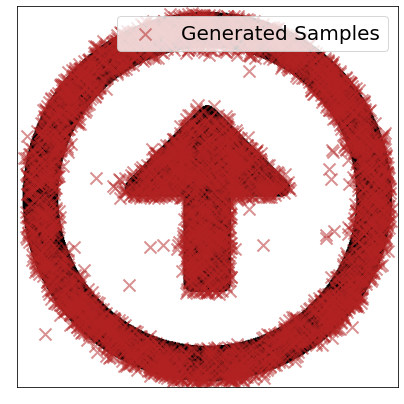

In [31]:
%%time

# generate samples from the learned distribution
samples = flow_dist.sample(torch.Size([5000,])).detach().numpy()
samples = (samples/2+0.5)*512

plt.figure(figsize=(7, 7))
show_grayscale_img(img,figsize=(7, 7))
plt.scatter(samples[:,0], samples[:,1], color='firebrick', label='Generated Samples', alpha=0.5,  marker='x')
plt.xlim([0,512])
plt.ylim([0,512])
plt.legend(loc="upper right")

<hr style='border:0.5px solid Gray'></hr>

We also want to have a look at the log-likelihood of our model!

Wall time: 1.09 s


Text(0.5, 1.0, 'Log-Likelihood')

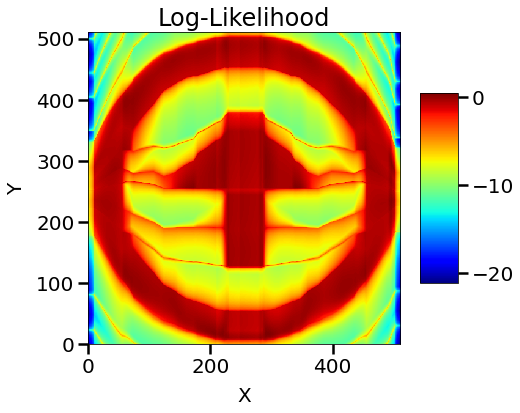

In [32]:
%%time

# compute the log-likelihood at a discrete grid
rows = np.arange(0, width)
cols = np.arange(0, height)

X, Y = np.meshgrid(cols, rows)

# flatten the grid points and evaluate their log-liklihoods
coordinates = torch.FloatTensor(np.stack((X,Y), axis=2)).view(-1, 2)
log_likelihood = flow_dist.log_prob((coordinates/512*2-1)).detach().view(-1,width).numpy()

# finally, let's plot the log-likelihood
fig, ax = plt.subplots(figsize=(7, 7))
levels = np.linspace(-18, 3, 20)
c = plt.imshow(log_likelihood, cmap = 'jet', vmin = np.min(log_likelihood), vmax = np.max(log_likelihood),
            extent =[X.min(), X.max(), Y.min(), Y.max()],
            interpolation ='nearest', origin ='lower')

plt.colorbar(c, shrink=0.5, aspect=5)
  
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Log-Likelihood')

<hr style='border:1.5px solid Black'></hr>
<hr style='border:0.5px solid Gray'></hr>

### Task b) Implement an autoregressive flow (spline autoregressive flow)

<hr style='border:0.5px solid Gray'></hr>
<hr style='border:1.5px solid Black'></hr>



Again, the base distribution is specified as a multivariate Gaussian with zero mean and unit covariance matrix: 

$$ \mathbf{X} \sim \mathcal{N}(\mu = \mathbf{0}_{2x1}, \Sigma = I_{2x2}) $$

The transformation of the random variable $\mathbf{X}$ with distribution $p_\mathbf{X}(\mathbf{x})$ by a function $\mathbf{g}(.)$ is performed by an autoregressive flow. The [autoregressive layer](https://docs.pyro.ai/en/stable/distributions.html#splineautoregressive) in our solution is implemented with spline functions. In task c) the *coupling* and *autoregressive* flow are explained in more detail and compared to each other.  

For the autoregressive spline layer the following parameters are specified:

* *input_dim* = 2
* *hidden_dim* = [input_dim x 30 &ensp; input_dim x 30]
* *count_bins* = 32
* *bound* = 3

which led to appropriate results.

In [33]:
from pyro.nn import AutoRegressiveNN

input_dim = 2
count_bins = 32
base_dist = dist.Normal(torch.zeros(input_dim), torch.ones(input_dim))
hidden_dims = [input_dim * 30]*10
param_dims = [count_bins, count_bins, count_bins - 1, count_bins]
hypernet = AutoRegressiveNN(input_dim, hidden_dims, param_dims=param_dims)
transform = T.SplineAutoregressive(input_dim, hypernet, count_bins=count_bins, bound=3)
flow_dist = dist.TransformedDistribution(base_dist, [transform])

<hr style='border:0.5px solid Gray'></hr>

**Training**:
Again, the parameters of the splines are learnt in a stochastic gradient descent where the log-likelihood is maximized (ML principle). 

The parameters of the stochastic gradient descent are chosen the same as in task a):

* *number of samples* = 2000
* *epochs* = 2000
* *learning_rate* = 2e-2

In [34]:
%%time

steps = 2_000

dataset = torch.tensor(data_normalized, dtype=torch.float)
optimizer = torch.optim.Adam(transform.parameters(), lr=2e-2)

for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))
        
print('Achieved log-likelihood: ', -loss.item())

step: 0, loss: 2.2648754119873047
step: 500, loss: 0.4505634903907776
step: 1000, loss: 0.37544772028923035
step: 1500, loss: 0.4260619580745697
step: 2000, loss: 0.3877931535243988
Achieved log-likelihood:  -0.3877931535243988
Wall time: 2min 37s


<hr style='border:0.5px solid Gray'></hr>

Then 5000 samples are generated from the trained flow distribution and shown in a scatter plot with the original b/w picture.
Also for the autoregressive flow the generated samples are quite reasonable given the simple implementation of the normalizing flow with a quite short execution time. The are some outliers, but the location of most samples does not deviate too much.

Wall time: 74.8 ms


<Figure size 504x504 with 0 Axes>

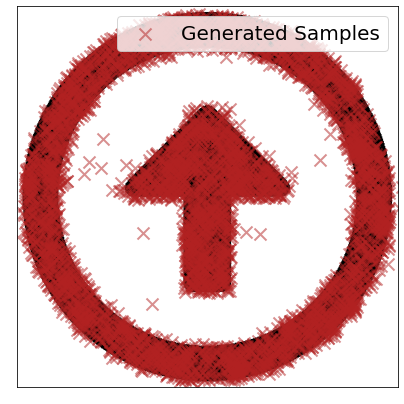

In [35]:
%%time

# generate samples from the learned distribution
samples = flow_dist.sample(torch.Size([5000,])).detach().numpy()
samples = (samples/2+0.5)*512

plt.figure(figsize=(7, 7))
show_grayscale_img(img,figsize=(7, 7))
plt.scatter(samples[:,0], samples[:,1], color='firebrick', label='Generated Samples', alpha=0.5, marker='x')
plt.xlim([0,512])
plt.ylim([0,512])
plt.legend(loc="upper right")

<hr style='border:0.5px solid Gray'></hr>

We also want to have a look at the log-likelihood of our model!

Wall time: 4.23 s


Text(0.5, 1.0, 'Log-Likelihood')

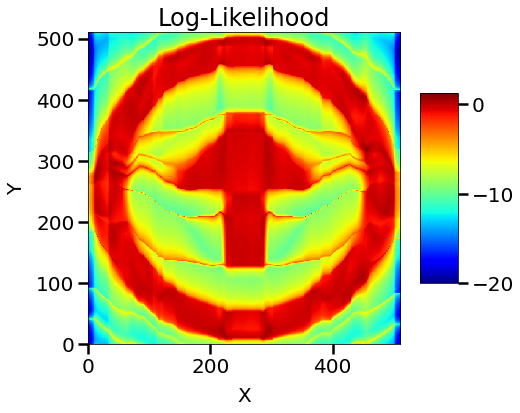

In [36]:
%%time

# compute the log-likelihood at a discrete grid
rows = np.arange(0, width)
cols = np.arange(0, height)

X, Y = np.meshgrid(cols, rows)

# flatten the grid points and evaluate their log-liklihoods
coordinates = torch.FloatTensor(np.stack((X,Y), axis=2)).view(-1, 2)
log_likelihood = flow_dist.log_prob((coordinates/512*2-1)).detach().view(-1,width).numpy()

# finally, let's plot the log-likelihood
fig, ax = plt.subplots(figsize=(7, 7))
levels = np.linspace(-18, 3, 20)
c = plt.imshow(log_likelihood, cmap = 'jet', vmin = np.min(log_likelihood), vmax = np.max(log_likelihood),
            extent =[X.min(), X.max(), Y.min(), Y.max()],
            interpolation ='nearest', origin ='lower')
plt.colorbar(c, shrink=0.5, aspect=5)
  
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Log-Likelihood')

<hr style='border:1.5px solid Black'></hr>
<hr style='border:0.5px solid Gray'></hr>

### Task c) Comparison: coupling vs autoregressive flow

<hr style='border:0.5px solid Gray'></hr>
<hr style='border:1.5px solid Black'></hr>


As mentioned earlier, normalizing flows make use of the *change-of-variables* formula in order to approximate a probability distribution given some samples drawn from it. Starting point is a simple base distribution, e.g. a zero-mean, unit variance Gaussian distribution $\mathbf{X} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$ that can be generated easily. This random variable is then transformed by a bijective function $\mathbf{g}(.)$ whose inverse also has to exist and be differentiable.

\begin{align}
     p_\mathbf{Y}(\mathbf{y}) = p_\mathbf{X}\left(\mathbf{g}^{-1}(\mathbf{y})\right)~\left|~\det\left(~\frac{d\mathbf{g}^{-1}(\mathbf{y})}{d\mathbf{x}}~\right)~\right|.
\end{align}

The target distribution is then approximated by transforming the base distribution by this function. The function can be determined by maximizing the log-likelihood e.g. with a stochastic gradient descent.

<hr style='border:0.5px solid Gray'></hr>

### Coupling flows:



The vector valued derivative of the inverse function is also known as the Jacobian matrix. The complexity of the computation of the determinant of the Jacobian matrix scales as $\mathcal{O}(n^3)$ with n being the dimension of the data ($\mathbf{x} \in \mathbb{R}^n$). Therefore, we would like to have some efficient implementation of the determinant of the Jacobian.
In coupling flows we make use of the fact that the determinant of a lower (or upper) triangular matrix is the product of the diagonal entries. For a more detailed description of coupling flows see the paper [**Neural Spline Flows**](https://papers.nips.cc/paper/2019/file/7ac71d433f282034e088473244df8c02-Paper.pdf), the following information about coupling flows is taken from there.

**Summary**:

* The input vector $\mathbf{x}$ is split into two parts: $[\mathbf{x}_{1:d},~\mathbf{x}_{d+1:D}]$
* The first part of the vector is mapped directly to the output vector, i.e. $\mathbf{y}_{1:d} = \mathbf{x}_{1:d}$
* Using the first part of the vector, we compute parameters $\Theta=c(\mathbf{x}_{1:d})$, where $c(.)$ can be a deep neural network
* These parameters are used to parameterize the function $g_\Theta$ that is used to map the second part of the input vector to the output vector $\mathbf{y}_{i} = g_{\Theta_i}(\mathbf{x}_{i})$ for $i = d+1,\dots,D$. This element-wise mapping can be performed in parallel for each $i$.

As the first part of the input vector is mapped one-to-one directly to the first part of the output vector, the Jacobian of the function $\mathbf{g}(.)$ is an upper diagonal matrix of the form

$$\frac{\partial g^{-1}}{\partial \mathbf{x}} = \begin{pmatrix}
 \mathbf{I} & \mathbf{0} \\
 \frac{\partial c}{\partial \mathbf{x}} & \frac{\partial g_{\Theta}^{-1}}{\partial \mathbf{x}} \\
\end{pmatrix}$$

and the computation of the determinant simplifies to

$$det\left( \frac{\partial g^{-1}}{\partial \mathbf{x}} \right) = \prod\limits_{i=d+1}^D \frac{\partial g_{\Theta_i}^{-1}}{\partial \mathbf{x}} ~~.$$